In [ ]:
# import vis
import matplotlib.pyplot as plt
import numpy as np
from src.config import Config
import os, glob, re

In [26]:
cfg_file="/Users/xinyi/Documents/GitHub/udp/env/online_cfg.json"
cfg = Config(cfg_file)
cfg.normalized_target_values, cfg.state_limits, cfg.target_names


(array([0.33333333, 0.8       , 0.41176471, 0.75      ]),
 {'max_knee_position_st': [20, 45],
  'min_knee_position_st': [18, 35],
  'max_knee_position_sw': [40, 80],
  'min_knee_position_sw': [15, 30]},
 ['min_knee_position_sw',
  'max_knee_position_st',
  'min_knee_position_st',
  'max_knee_position_sw'])

No CSVs in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory/memory_online_iter_0.csv
Plotting 3 CSV(s) in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1
Saving figure to /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1/fig_memory_online_iter_0.png
Saving figure to /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1/fig_memory_online_iter_1.png
Saving figure to /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1/fig_memory_online_iter_2.png
No CSVs in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1/memory_online_iter_0.csv
No CSVs in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1/memory_online_iter_1.csv
No CSVs in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_1/memory_online_iter_2.csv
Plotting 4 CSV(s) in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_2
Saving figure to /Users/xinyi/Documents/Data/ossur/OT_08_26/online/memory_2/fig_memory_online_iter_0.png
Saving figure to /Users/xinyi/Documents/Da

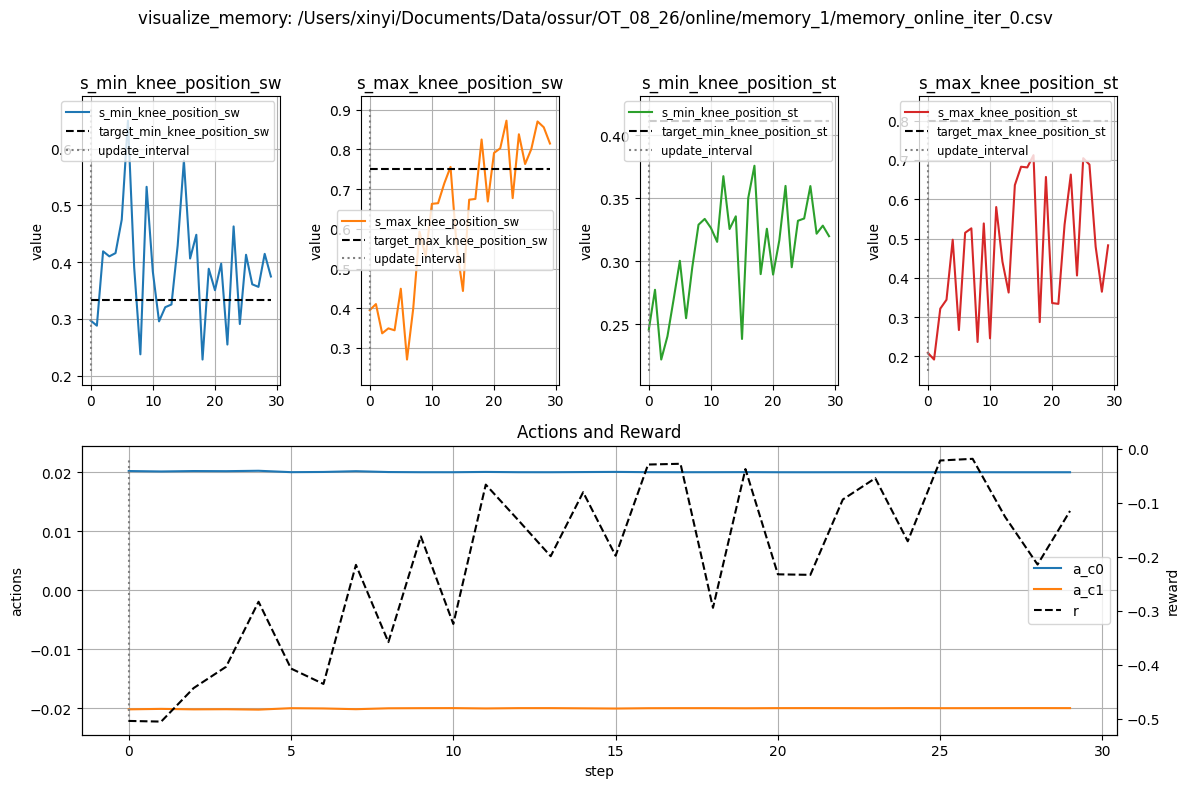

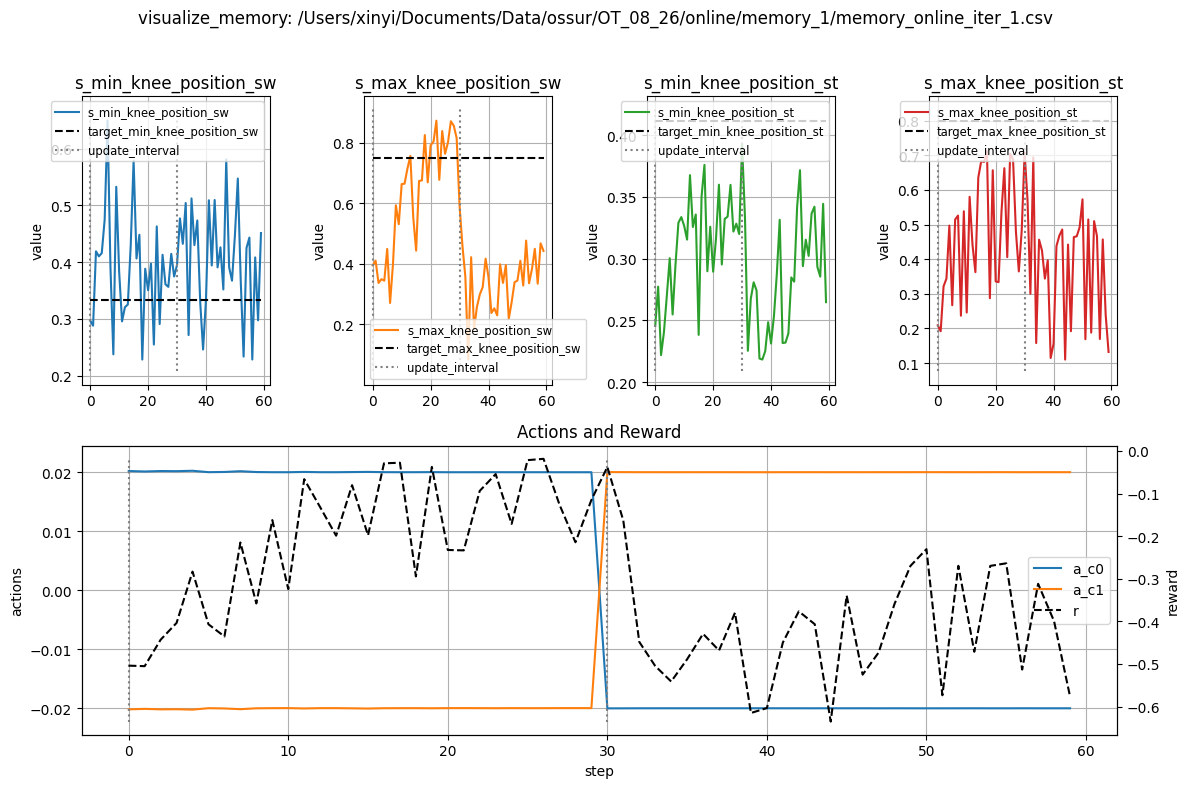

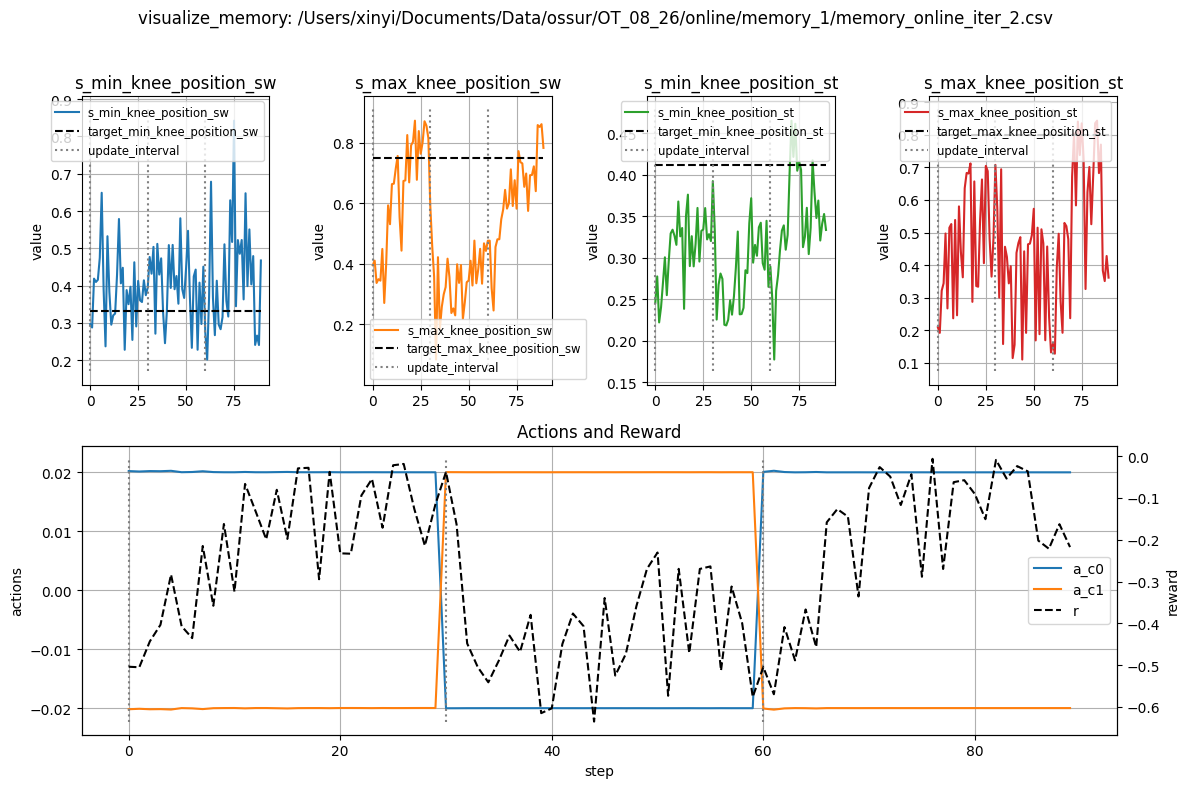

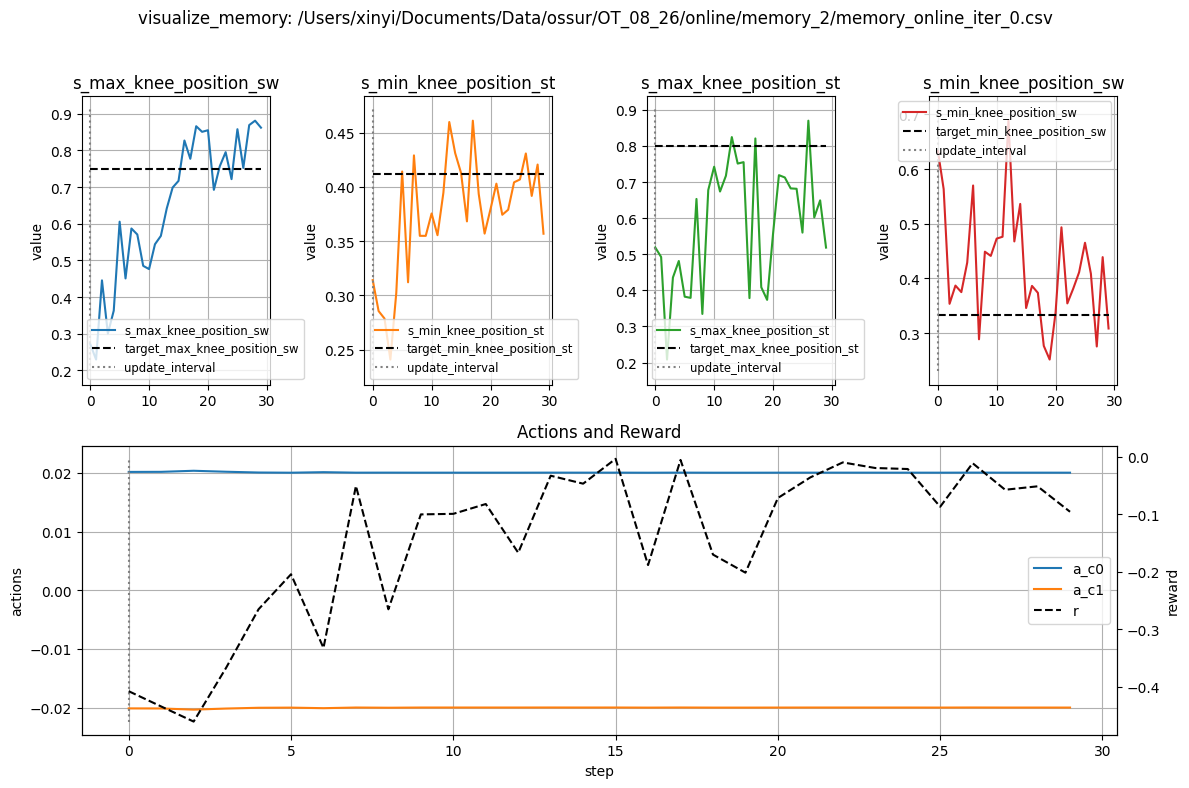

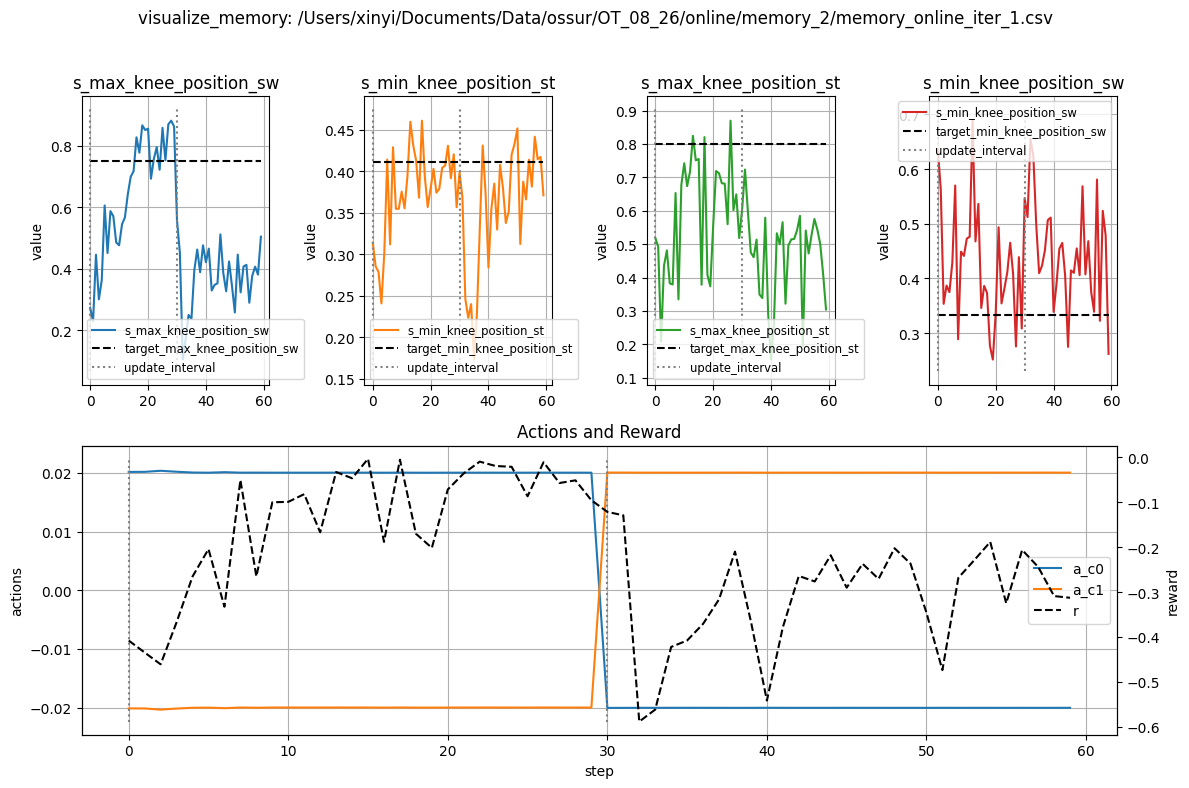

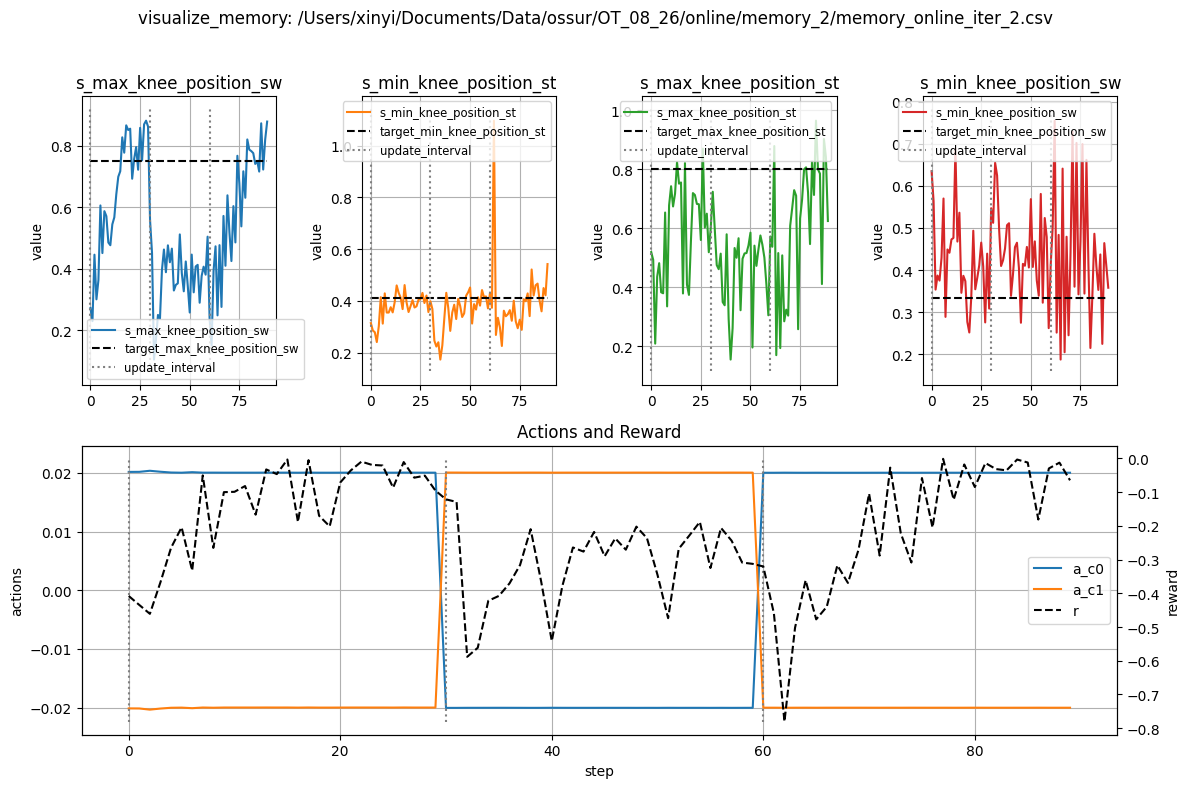

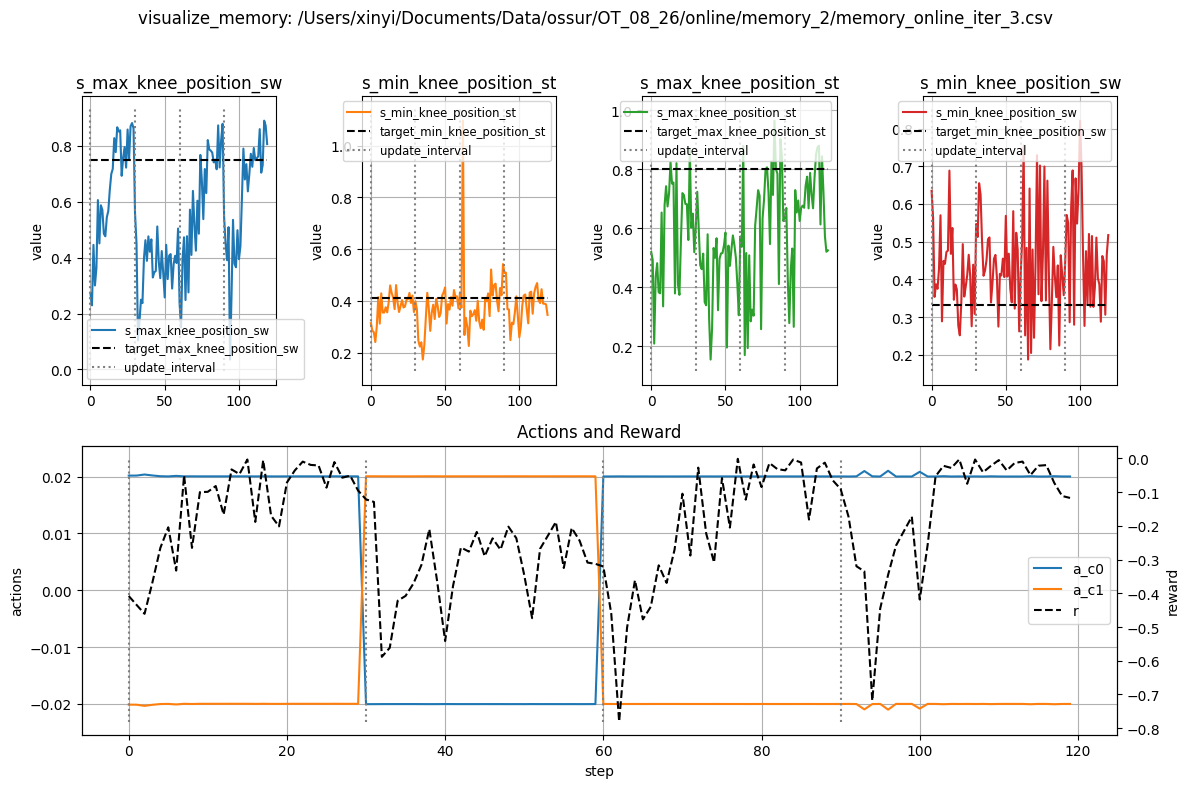

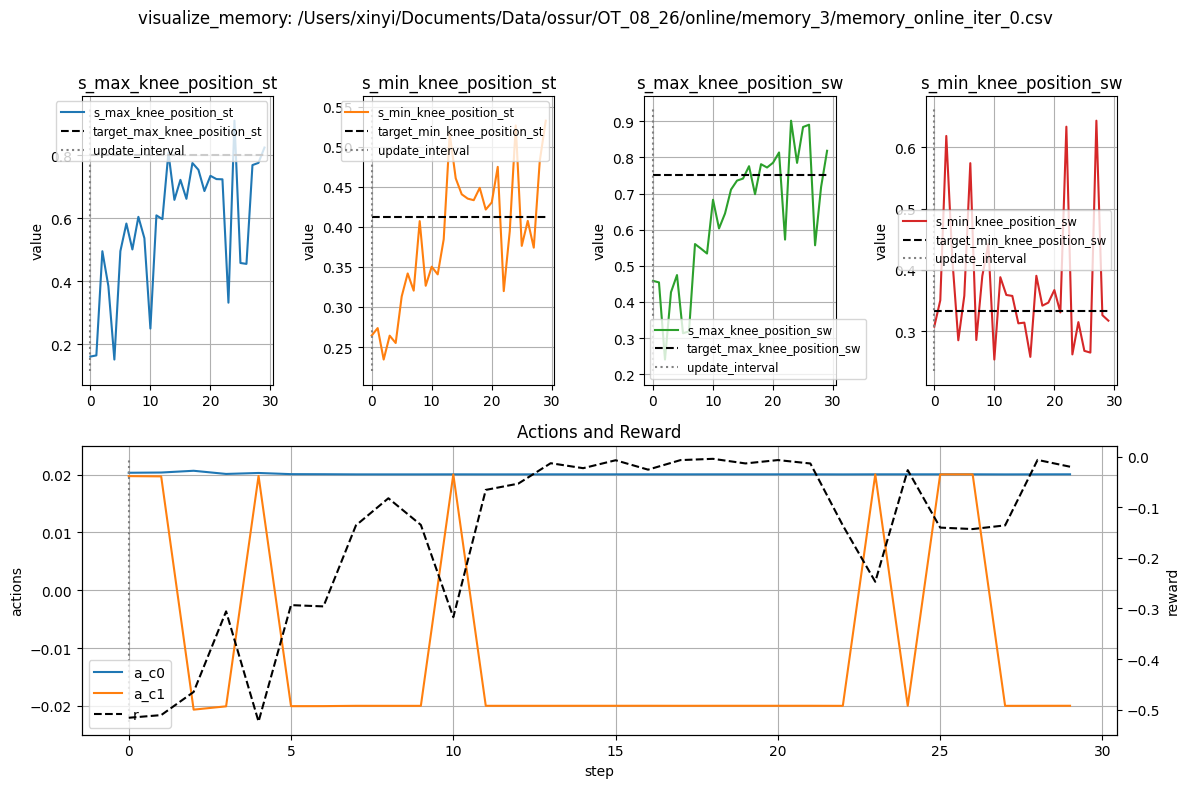

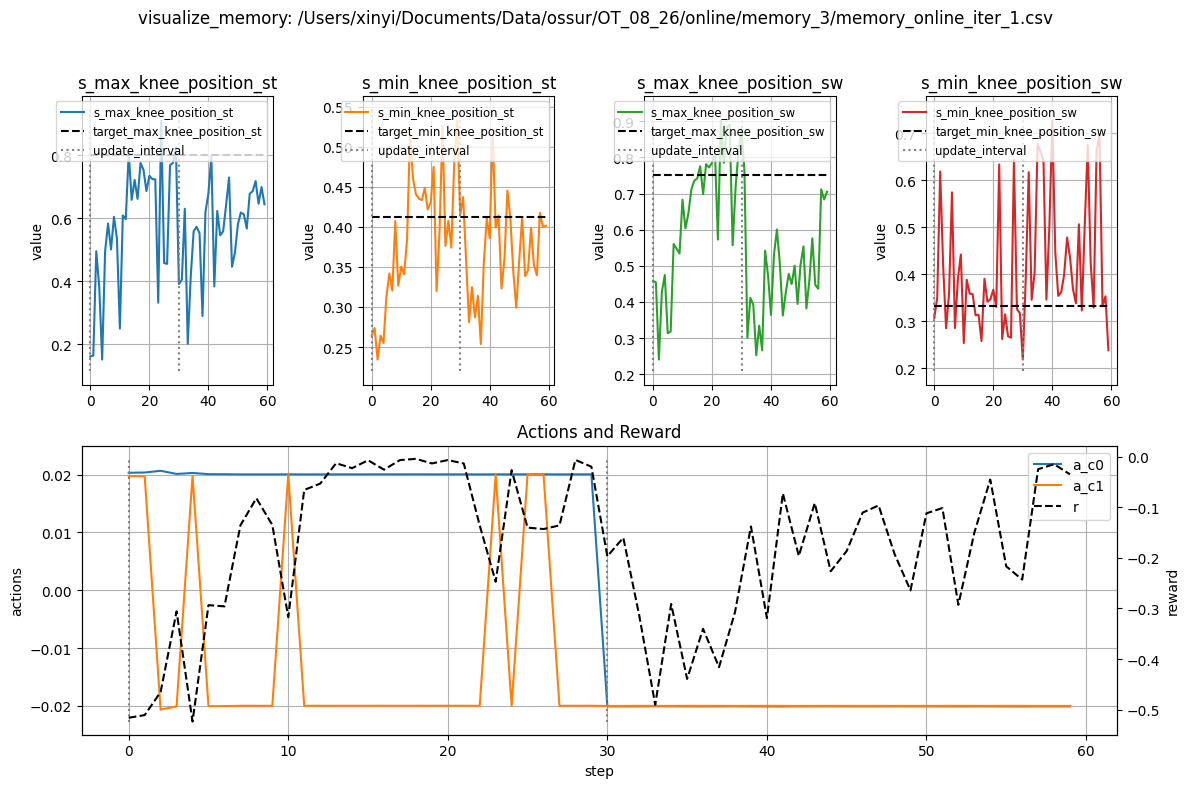

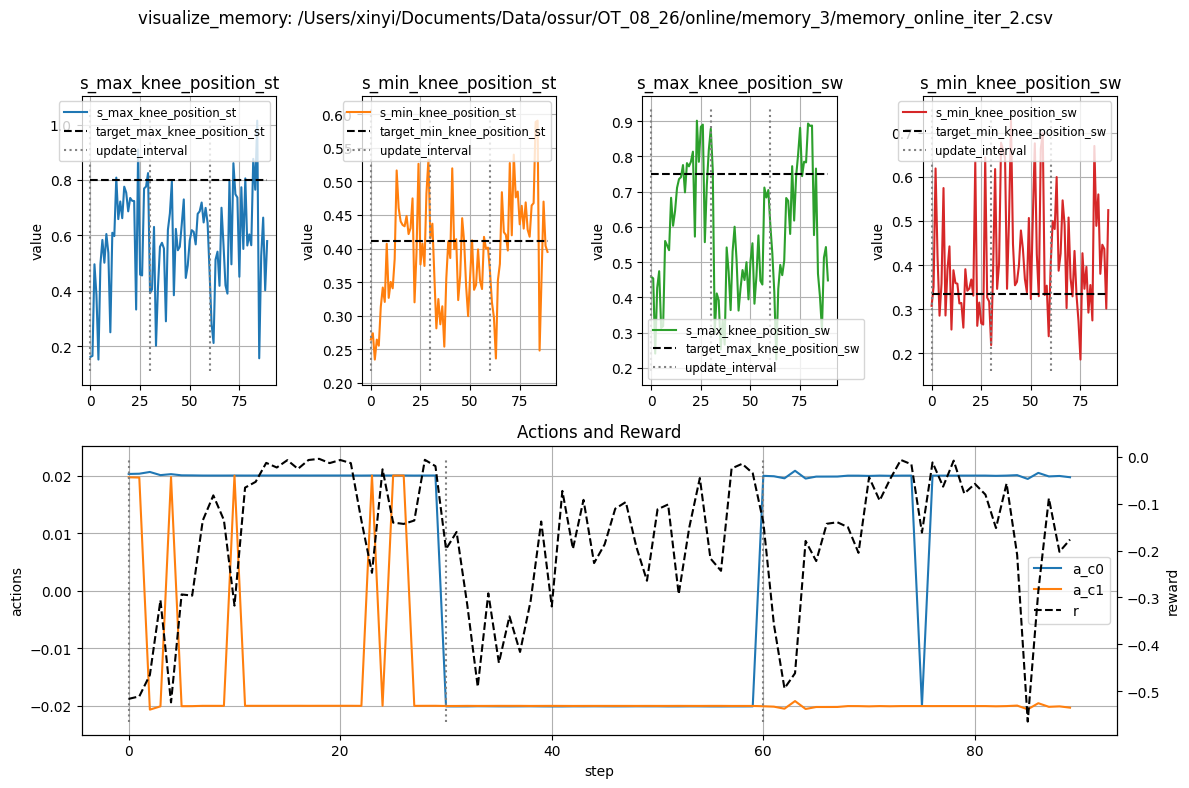

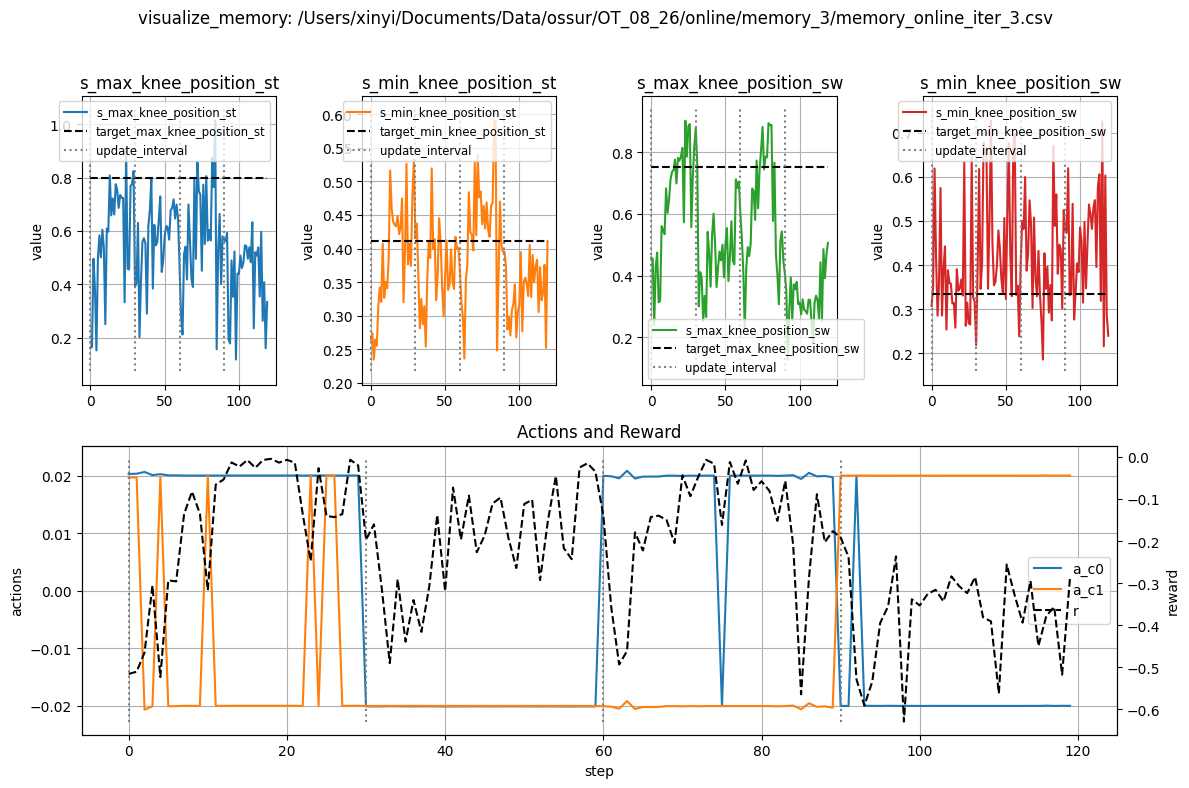

In [73]:


# visualize memory
def visualize_memory(file_path, cfg_file = None, savefigto=None):
    # load data, column name from first row
    data = np.genfromtxt(file_path, delimiter=',', comments='#', autostrip=True, dtype=None, encoding=None)
    # read # columns names from first row
    with open(file_path, 'r') as f:
        first_line = f.readline().strip()
    col_names = [name.strip() for name in first_line.lstrip('#').split(',')]
    
    data = np.asarray(data)

    if cfg_file is not None:
        cfg = Config(cfg_file)

    t = np.arange(data.shape[0])

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # replace the single top subplot with a 2 x (n/2) grid of subplots (top row = state dims, bottom = actions+reward)
    fig.clf()
    n = cfg.state_dim if cfg_file is not None else 4  # number of state dimensions to plot
    # determine state columns (first 8 columns are state-related)
    state_cols = list(range(4)) if cfg_file is None else list(range(cfg.state_dim))

    gs = fig.add_gridspec(2, n, height_ratios=[1, 1])

    # create one subplot per state dim in the top row
    top_axes = []
    colors = plt.rcParams.get("axes.prop_cycle").by_key().get("color", ["C0", "C1", "C2", "C3"])
    for i, col_idx in enumerate(state_cols):
        r = 0
        c = i % n
        ax = fig.add_subplot(gs[r, c])
        ax.plot(t, data[:, col_idx], label=col_names[col_idx], color=colors[i % len(colors)])
        ax.set_title(col_names[col_idx])
        ax.set_ylabel("value")
        ax.grid(True)

        if cfg_file is not None:
            normalized_targets = {cfg.target_names[j]: cfg.normalized_target_values[j] for j in range(len(cfg.normalized_target_values))}
            col_name = col_names[col_idx]
            # delete s_ or s_next_ prefix if exists
            if col_name.startswith("s_"):
                col_name = col_name[2:]
            elif col_name.startswith("s_next_"):
                col_name = col_name[7:]
            if col_name in normalized_targets.keys():
                # print(f"Overlaying target for {col_name}: {normalized_targets[col_name]}")
                r = 0
                c = i % n
                ax.hlines(normalized_targets[col_name], xmin=0, xmax=t[-1],
                            colors="k", linestyles="--", label=f"target_{col_name}")
                # vertical line every lspi_cfg.update_size steps
                ax.vlines(np.arange(0, t[-1], cfg.lspi_cfg.update_size), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],
                          colors="gray", linestyles="dotted", label="update_interval") 

        ax.legend(loc="best", fontsize="small")
        top_axes.append(ax)

    # bottom row: actions + reward spanning all columns
    ax_actions = fig.add_subplot(gs[1, :])

    # keep compatibility with later code that expects axs[1] to be the actions axis
    # set axs[0] to the first top axis (exists because n>=1), axs[1] to the actions axis
    axs = [top_axes[0] if top_axes else ax_actions, ax_actions]


    # actions and reward (actions on left, reward on right)
    ax_actions = axs[1]
    ax_reward = ax_actions.twinx()
    ax_actions.plot(t, data[:, 8], label=col_names[8], color="C0")
    ax_actions.plot(t, data[:, 9], label=col_names[9], color="C1")
    ax_reward.plot(t, data[:, 10], label=col_names[10], color="k", linestyle="--")
    ax_actions.set_ylabel("actions")
    ax_reward.set_ylabel("reward")
    lines, labels = ax_actions.get_legend_handles_labels()
    lines2, labels2 = ax_reward.get_legend_handles_labels()
    ax_actions.legend(lines + lines2, labels + labels2, loc="best")
    ax_actions.grid(True)
    ax_actions.set_title("Actions and Reward")
        
    if cfg_file is not None:
        # vertical line every lspi_cfg.update_size steps
        ax_actions.vlines(np.arange(0, t[-1], cfg.lspi_cfg.update_size), ymin=ax_actions.get_ylim()[0], ymax=ax_actions.get_ylim()[1],
                          colors="gray", linestyles="dotted", label="update_interval") 

    axs[1].set_xlabel("step")

    
    plt.suptitle(f"visualize_memory: {file_path}")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if savefigto is not None:
        print(f"Saving figure to {savefigto}")
        plt.savefig(savefigto)  
    else:
        plt.show()

# example usage
# search for memory_* folders starting from cwd and the folder containing cfg_file
roots = ["/Users/xinyi/Documents/Data/ossur/OT_08_26/online/"]
memory_dirs = set()
for root in roots:
    memory_dirs.update(glob.glob(os.path.join(root, '**', 'memory_*'), recursive=True))
memory_dirs = sorted(memory_dirs)


if not memory_dirs:
    print("No memory_* directories found under:", roots)
else:
    # natural sort helper (so iteration files like ..._1.csv, ..._2.csv sort correctly)
    def _natkey(s):
        return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', os.path.basename(s))]
    for mem_dir in memory_dirs:
        csv_files = sorted(glob.glob(os.path.join(mem_dir, '*.csv')), key=_natkey)
        if not csv_files:
            print("No CSVs in", mem_dir)
            continue
        print("Plotting", len(csv_files), "CSV(s) in", mem_dir)
        for csv_path in csv_files:
            visualize_memory(csv_path, cfg_file=cfg_file, savefigto=os.path.join(mem_dir, f"fig_{os.path.basename(csv_path).rsplit('.',1)[0]}.png")) 


Found 4 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/weights/weights_rep_3.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1/weights_online_iter_0.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1/weights_online_iter_1.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1/weights_online_iter_2.npz:
  weights: shape (21,)


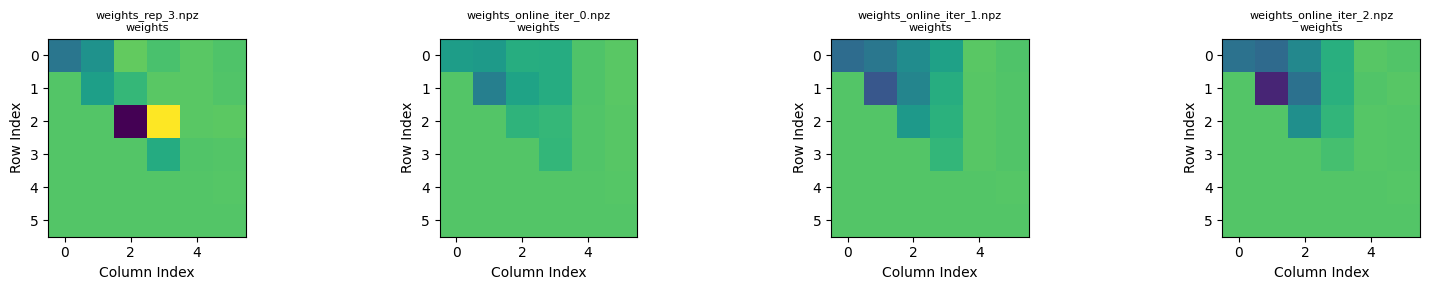


Found 5 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_3
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/weights/weights_rep_3.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_3/weights_online_iter_0.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_3/weights_online_iter_1.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_3/weights_online_iter_2.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_3/weights_online_iter_3.npz:
  weights: shape (21,)


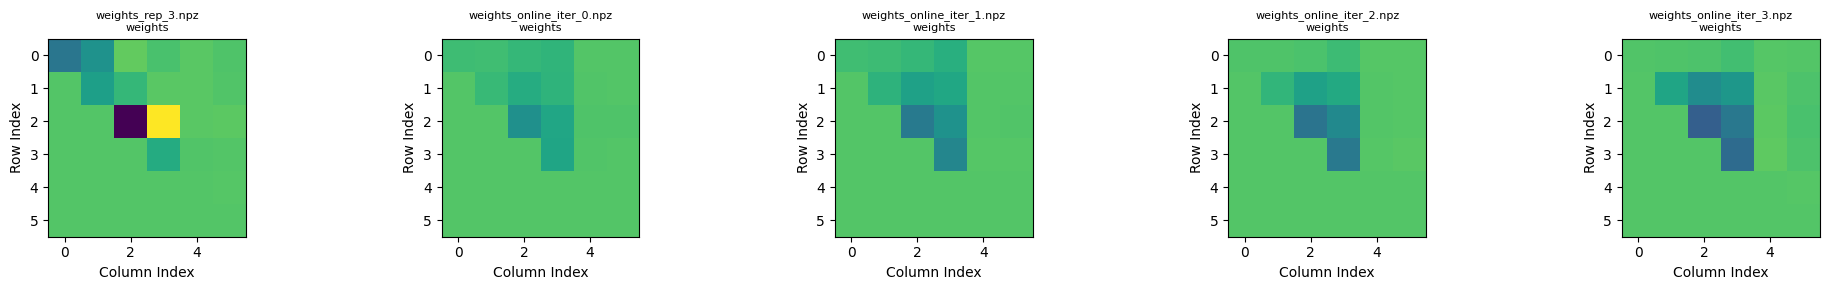


Found 5 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_2
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/weights/weights_rep_3.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_2/weights_online_iter_0.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_2/weights_online_iter_1.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_2/weights_online_iter_2.npz:
  weights: shape (21,)
Weights from /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_2/weights_online_iter_3.npz:
  weights: shape (21,)


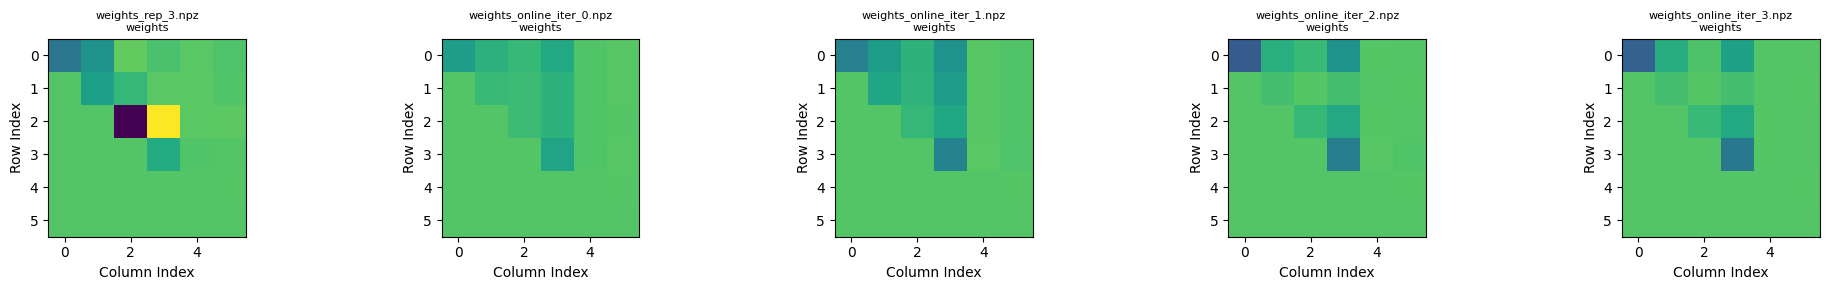


Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weight/weights_online.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1/weights_online_iter_1.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1/weights_online_iter_0.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_1/weights_online_iter_2.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights/weights_online_iter_0.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weight_1/weights_online.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/online/weights_3/weights_online_iter_1.npz
No weight arrays to plot.
Found 0 weight files in /Users/xinyi/Documents/Data/ossur/OT_08_26/

In [93]:
weight_dirs = set()
for root in roots:
    weight_dirs = glob.glob(os.path.join(root, '**', 'weights_*'), recursive=True)
if not weight_dirs:
    print("No weights_* directories found under:", roots)
else:
    for weight_dir in weight_dirs:
        weight_files = sorted(glob.glob(os.path.join(weight_dir, '*.npz')), key=_natkey)
        weight_files.insert(0, os.path.join(cfg.policy_path, "weights", "weights_rep_3.npz")) if weight_files else None
        print("Found", len(weight_files), "weight files in", weight_dir)
       
        matrices = []
        for weight_path in weight_files:
            with np.load(weight_path, allow_pickle=True) as weights:
                print(f"Weights from {weight_path}:")
                for k in weights.files:
                    v = weights[k]
                    print(f"  {k}: shape {v.shape}")
                    if v.ndim != 2:
                        # convert flattened upper-triangular storage to square matrix
                        size = int((np.sqrt(8 * v.size + 1) - 1) / 2)
                        upper_tri = np.zeros((size, size))
                        upper_tri[np.triu_indices(size)] = v
                        mat = upper_tri
                    else:
                        mat = v
                    matrices.append((os.path.basename(weight_path), k, mat))

        if not matrices:
            print("No weight arrays to plot.")
            continue

        # consistent color scaling across all subplots
        all_vals = np.hstack([m.ravel() for _, _, m in matrices])
        vmin, vmax = all_vals.min(), all_vals.max()

        n_plots = len(matrices)
        ncols = min(6, n_plots)
        nrows = int(np.ceil(n_plots / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
        axes = np.array(axes).reshape(-1)

        im = None
        for ax, (fname, k, mat) in zip(axes, matrices):
            im = ax.imshow(mat, cmap='viridis', aspect='equal', vmin=vmin, vmax=vmax)
            ax.set_title(f"{fname}\n{k}", fontsize=8)
            ax.set_xlabel("Column Index")
            ax.set_ylabel("Row Index")
            ax.grid(False)

        # turn off any unused axes
        for ax in axes[len(matrices):]:
            ax.axis("off")

        # # single shared colorbar
        # if im is not None:
        #     fig.colorbar(im, ax=axes[:len(matrices)].tolist(), shrink=1, label="Weight Value")

        plt.tight_layout()
        plt.show()
        print()